In [1]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
from math import acos, sqrt
import warnings

# Plotting
import matplotlib.pyplot as plt
import matplotlib 
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context("paper", font_scale=(1.4))
%matplotlib inline

from IPython.core.display import HTML; css_file = '../2019/style.css'; HTML(open(css_file, "r").read())

# MS²PIP 2023 manuscript - Figures

This notebook contains the generation of the figures for the MS²PIP 2022 manuscript:


The notebook requires the following files:


The notebook was run in Python 3.8.13 with the following packages:

ipython==8.4.0\
numpy==1.23.0\
pandas==1.4.3\
matplotlib==3.5.2\
seaborn==0.11.2

## Functions

In [2]:
def ms2pip_pearson(true, pred):
    """
    Return pearson of tic-normalized, log-transformed intensities, 
    the MS2PIP way.
    """
    #tic_norm = lambda x: x / np.sum(x)
    # log_transform = lambda x: np.log2(x + 0.001)
    corr = pearsonr(
        true, 
        pred
    )[0]
    return (corr)


def spectral_angle(true, pred, epsilon=1e-7):
    """
    Return square root normalized spectral angle.
    See https://doi.org/10.1074/mcp.O113.036475
    """
    
    de_log = lambda x: (2**x)-0.001
    l2_normalize = lambda x: x / sqrt(max(sum(x**2), epsilon))
    
    pred_norm = l2_normalize(de_log(pred))
    true_norm = l2_normalize(de_log(true))
    
    spectral_angle = 1 - (2 * acos(np.dot(pred_norm, true_norm)) / np.pi)

    return (spectral_angle)

def data_loading(filename, filename_mapper):
    ms2pip_models = {
        "_HCD2019_": "2019 HCD",
        "_Immuno-HCD_": "immunopeptide HCD",
        "_CID_": "CID",
        "_CID-TMT": "CID-TMT",
        "_HCD2021_": "2021 HCD",
        "_TMT_": "TMT"
    }

    test_df = pd.read_csv(filename)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        df = test_df.groupby(["spec_id"]).agg({"prediction": list, "target": list}).reset_index()
        df["pearson"] = df.apply(lambda x: ms2pip_pearson(x.target, x.prediction), axis=1)
        df["SA"] = df.apply(lambda x: spectral_angle(np.array(x.target), np.array(x.prediction)), axis=1)
        df["data"] = filename_mapper[filename]
        for model_name, model in ms2pip_models.items():
            if model_name in filename:
                ms2pip_model = model
        df["model"] = ms2pip_model

        return df[["spec_id", "pearson", "SA", "data", "model"]]

def convert_liststring_to_list(liststring):
    liststring = liststring[1:-1]
    return [float(x) for x in liststring.split(",")]    


## Loading the prediction files

In [3]:
data_set_map = {
    "HCD_PXD008034_Ecoli_HCD2021_pred_and_emp.csv": "trypsin",
    "HCD_PXD008034_Ecoli_HCD2019_pred_and_emp.csv": "trypsin",
    "HCD_PXD008034_Ecoli_Immuno-HCD_pred_and_emp.csv": "trypsin",
    "spec_lib_PXD005231_HCD2019_pred_and_emp.csv": "HLA-I",
    "spec_lib_PXD005231_HCD2021_pred_and_emp.csv": "HLA-I",
    "spec_lib_PXD005231_Immuno-HCD_pred_and_emp.csv": "HLA-I",
    "spec_lib_pxd020011_Immuno-HCD_pred_and_emp.csv": "HLA-II",
    "spec_lib_pxd020011_HCD2019_pred_and_emp.csv": "HLA-II",
    "spec_lib_pxd020011_HCD2021_pred_and_emp.csv": "HLA-II",
    "test_spec_lib_PXD010154_HCD2021_pred_and_emp.csv": "chymotrypsin",
    "test_spec_lib_PXD010154_HCD2019_pred_and_emp.csv": "chymotrypsin",
    "test_spec_lib_PXD010154_Immuno-HCD_pred_and_emp.csv": "chymotrypsin"}

cid_tmt_map = {
        "spec_lib_pxd00589_CID-TMT_pred_and_emp.csv": "CID-TMT",
        "spec_lib_pxd00589_CID_pred_and_emp.csv": "CID-TMT",
        "spec_lib_pxd00589_TMT_pred_and_emp.csv": "CID-TMT",
}

In [4]:
non_tryptic_correlations = pd.concat([data_loading(file, data_set_map) for file in data_set_map.keys()])
# non_tryptic_correlations['data'] = pd.Categorical(non_tryptic_correlations['data'],
#                                    categories=['trypsin', 'chymotrypsin', 'HLA-I', 'HLA-II'],
#                                    ordered=True)
cid_tmt_correlations = pd.concat([data_loading(file, cid_tmt_map) for file in cid_tmt_map.keys()])

FileNotFoundError: [Errno 2] No such file or directory: 'HCD_PXD008034_Ecoli_HCD2021_pred_and_emp.csv'

# Figure 1: Boxplots for novel tryptic models 

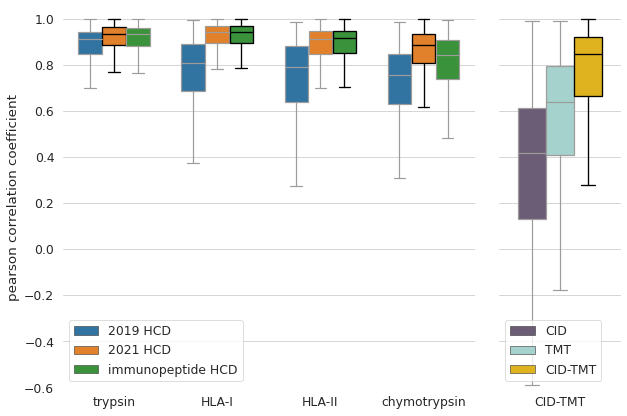

In [ ]:
fig = plt.Figure(figsize=(10,7))
ax1 = plt.subplot2grid((1,4),(0,0), colspan=3, fig=fig)
sns.boxplot(
    data=non_tryptic_correlations,
    x="data",
    y="pearson",
    hue="model",
    showfliers= False,
    hue_order=["2019 HCD", "2021 HCD", "immunopeptide HCD"],
    ax=ax1,
    width=0.7,
    palette=sns.color_palette()

)
ax1.set_ylim(-0.6,1.1)
ax1.set_xlabel("")
ax1.get_legend().set_title("")
ax1.set_ylabel("pearson correlation coefficient")
ax1.legend(loc=0)

best_model_boxplots= [2,6,9,11]
count = 0
for i, obj in enumerate(ax1.get_children()):
    if type(obj) == matplotlib.patches.PathPatch:
        count += 1
        if count not in best_model_boxplots:
            # obj.set_alpha(0.75)
            obj.set_edgecolor("#9e9b9b")
        else:
            # obj.set_alpha(0.75)
            obj.set_edgecolor("#000000")
            obj.set_linewidth(1.33)
        
    elif type(obj) == matplotlib.lines.Line2D:
        if count not in best_model_boxplots:
            obj.set_color("#9e9b9b")
        else:
            obj.set_color("#000000")
            obj.set_linewidth(1.33)
sns.despine(ax=ax1, left=True, bottom=True)
ax2 = plt.subplot2grid((1,4),(0,3), colspan=1, fig=fig, sharey=ax1)

sns.boxplot(
    data=cid_tmt_correlations,
    x="data",
    y="pearson",
    hue="model",
    showfliers= False,
    hue_order=[ "CID", "TMT", "CID-TMT"],
    ax=ax2,
    width=0.7,
    palette=sns.color_palette(["#6d597a","#9dd9d2" ,"#ffc300"])
)

best_model_boxplots= [3]
count = 0
for i, obj in enumerate(ax2.get_children()):
    if type(obj) == matplotlib.patches.PathPatch:
        count += 1
        if count not in best_model_boxplots:
            # obj.set_alpha(0.75)
            obj.set_edgecolor("#9e9b9b")
        else:
            # obj.set_alpha(0.75)
            obj.set_edgecolor("#000000")
            obj.set_linewidth(1.33)
        
    elif type(obj) == matplotlib.lines.Line2D:
        if count not in best_model_boxplots:
            obj.set_color("#9e9b9b")
        else:
            obj.set_color("#000000")
            obj.set_linewidth(1.33)

ax2.set_ylim(-0.6,1.05)
ax2.set_ylabel("")
ax2.set_xlabel("")
ax2.tick_params(labelleft=False)
ax2.get_legend().set_title("")
sns.despine(ax=ax2, left=True, bottom=True)

fig.savefig("pearson_corr_plot.svg")
fig

In [ ]:
non_tryptic_correlations.groupby(["data", "model"]).agg({"pearson": "median", "spec_id": "count"})

pearson  spec_id
data         model                               
HLA-I        2019 HCD           0.805887    12534
             2021 HCD           0.939815    12534
             immunopeptide HCD  0.942002    12534
HLA-II       2019 HCD           0.791316    12745
             2021 HCD           0.911232    12745
             immunopeptide HCD  0.913439    12745
chymotrypsin 2019 HCD           0.756812    25798
             2021 HCD           0.886789    25570
             immunopeptide HCD  0.842392    25798
trypsin      2019 HCD           0.910123    35212
             2021 HCD           0.934454    35212
             immunopeptide HCD  0.932352    35212

In [ ]:
cid_tmt_correlations.groupby(["data", "model"]).agg({"pearson": "median", "spec_id": "count"})

pearson  spec_id
data    model                     
CID-TMT CID      0.417447    69768
        CID-TMT  0.844415    69768
        TMT      0.639954    69768

## Figure S1: chymotrypsin predictions based on length

In [ ]:
peprec_pxd010154 = pd.read_table("test_spec_lib_PXD010154.peprec", sep=" ")
chymotrypsin = non_tryptic_correlations[non_tryptic_correlations["data"] == "chymotrypsin"]
chymotrypsin["length"] = chymotrypsin["spec_id"].map(dict(zip(peprec_pxd010154["spec_id"], peprec_pxd010154["peptide"].apply(len))))

/tmp/ipykernel_3529642/713219926.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chymotrypsin["length"] = chymotrypsin["spec_id"].map(dict(zip(peprec_pxd010154["spec_id"], peprec_pxd010154["peptide"].apply(len))))


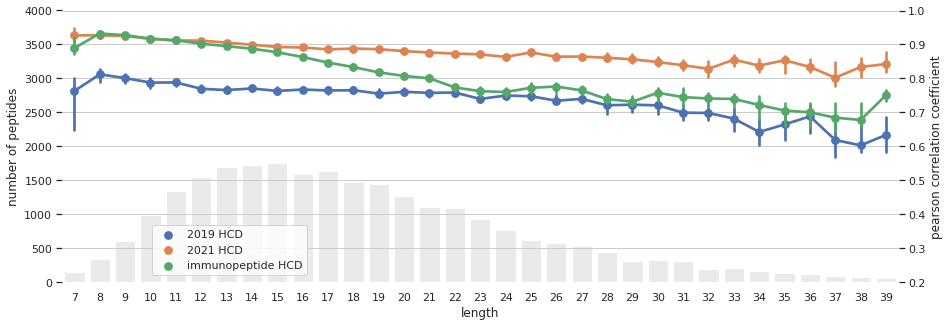

In [ ]:
fig = plt.figure()
sns.set(style="whitegrid")

ax = sns.countplot(
x="length",
data=chymotrypsin[chymotrypsin["model"] == "2019 HCD"],
color="#EAEAEA")
ax.set_ylabel("number of peptides")
ax.set_ylim([0,4000])
sns.despine(ax=ax, left=True, bottom=True)

ax2=ax.twinx()
sns.pointplot(
    x="length",
    y="pearson",
    hue="model",
    hue_order=["2019 HCD", "2021 HCD", "immunopeptide HCD"],
    showfliers=False,
    data=chymotrypsin[chymotrypsin["length"] < 40],
    legend=False,
    ax=ax2,
    estimator=np.median,
)
ax2.set_ylim([0.25,1])
ax2.set_ylabel("pearson correlation coefficient")
# ax2.set_xlim(-1,35.5)
ax2.legend(bbox_to_anchor=(.30, 0.23), frameon=True)
ax2.set_yticks(np.linspace(ax2.get_yticks()[0], ax2.get_yticks()[-1], len(ax.get_yticks())))
# ax2.set_yticklabels(np.round(ax2.get_yticks(), 2))
sns.despine(ax=ax2, left=True, bottom=True)

fig.set_size_inches(15, 5)
plt.savefig("chymotrypsin_length_perf.svg")
plt.show()

## Figure S2: HLA-I/ HLA-II pattern analysis

In [ ]:
peprec_pxd005231 = pd.read_table("spec_lib_PXD005231.peprec", sep=" ")
peprec_pxd020011 = pd.read_table("spec_lib_pxd020011.peprec", sep=" ")
peprec_immunopeptides = pd.concat([peprec_pxd005231, peprec_pxd020011])

immunopeptides = non_tryptic_correlations[non_tryptic_correlations["data"].isin(["HLA-I", "HLA-II"])]
immunopeptides["length"] = immunopeptides["spec_id"].map(dict(zip(peprec_immunopeptides["spec_id"], peprec_immunopeptides["peptide"].apply(len))))
immunopeptides.reset_index(inplace=True,drop=True)

/tmp/ipykernel_3529642/4116498480.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  immunopeptides["length"] = immunopeptides["spec_id"].map(dict(zip(peprec_immunopeptides["spec_id"], peprec_immunopeptides["peptide"].apply(len))))


In [ ]:
immunopeptides_count = immunopeptides[immunopeptides["model"] == "immunopeptide HCD"].groupby(["data", "length"]).agg({"spec_id": "count"}).reset_index()

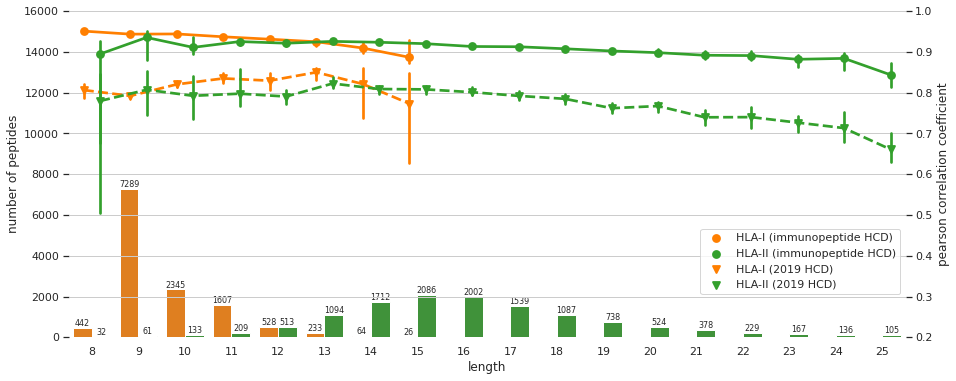

In [ ]:
fig = plt.figure(figsize=(15, 6))
sns.set(style="whitegrid")

ax = sns.countplot(
    x="length",
    hue="data",
    data=immunopeptides[immunopeptides["model"] == "immunopeptide HCD"],
    palette="Paired_r")

ax.bar_label(ax.containers[0],size=8)
ax.bar_label(ax.containers[1],size=8)
ax.get_legend().remove()
ax.set_ylabel("number of peptides")
ax.set_ylim([0,16000])
sns.despine(ax=ax, left=True, bottom=True)

ax2=ax.twinx()
sns.pointplot(
    x="length",
    y="pearson",
    hue="data",
    # hue_order=["2019 HCD", "2021 HCD", "immunopeptide HCD"],
    # showfliers=False,
    data=immunopeptides[immunopeptides["model"] == "immunopeptide HCD"],
    legend= False,
    ax=ax2,
    dodge=0.35,
    palette="Paired_r",
    estimator=np.median,

    )

sns.pointplot(
    x="length",
    y="pearson",
    hue="data",
    markers="v",
    linestyles="--",
    data=immunopeptides[immunopeptides["model"] == "2019 HCD"],
    legend= False,
    ax=ax2,
    dodge=0.35,
    palette="Paired_r",
    estimator=np.median,

    )
ax2.axes.set_ylim([0.25,0.95])
ax2.set_ylabel("pearson correlation coefficient")
ax2.set_yticks(np.linspace(ax2.get_yticks()[0], ax2.get_yticks()[-1], len(ax.get_yticks())))
sns.despine(ax=ax2, left=True, bottom=True)

handles, labels = ax2.get_legend_handles_labels()
ax2.legend(bbox_to_anchor=(1, 0.35), frameon=True,handles=handles[0:], labels=["HLA-I (immunopeptide HCD)", "HLA-II (immunopeptide HCD)","HLA-I (2019 HCD)", "HLA-II (2019 HCD)"])
plt.savefig("immunopeptides_length_perf.svg")
plt.show()

## Figure S2: intensity variance 

In [ ]:
correlation_df = pd.read_table("intensity_comparison_dataframe.txt", sep="\t")
for target in ["target_cid", "target_tmt", "target_cid_tmt"]:
    correlation_df[target] = correlation_df[target].apply(convert_liststring_to_list)


correlation_df["CID vs HCD-TMT"] = correlation_df.apply(lambda x: ms2pip_pearson(x.target_cid, x.target_tmt), axis=1)
correlation_df["CID vs CID-TMT"] = correlation_df.apply(lambda x: ms2pip_pearson(x.target_cid, x.target_cid_tmt), axis=1)
correlation_df["HCD-TMT vs CID-TMT"] = correlation_df.apply(lambda x: ms2pip_pearson(x.target_tmt, x.target_cid_tmt), axis=1)



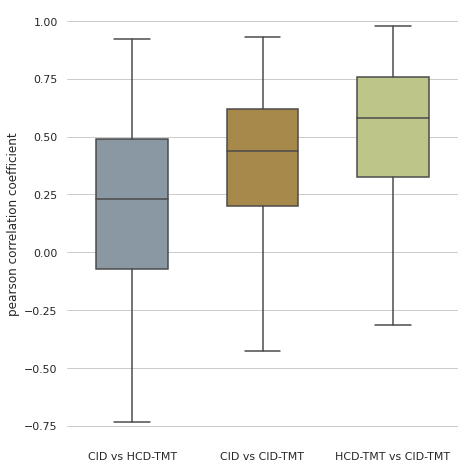

In [ ]:
fig = plt.Figure(figsize=(7,8))
ax = fig.add_subplot(111)
sns.boxplot(
    data=correlation_df.melt(id_vars=["peptide", "charge"], value_vars=["CID vs HCD-TMT", "CID vs CID-TMT", "HCD-TMT vs CID-TMT"], var_name="comparison", value_name="correlation"),
    x="comparison",
    y="correlation",
    width=0.55,
    palette=sns.color_palette(["#8599a6", "#b68e3d", "#c4d07e"]),
    showfliers=False,
    ax=ax
)
ax.set_ylabel("pearson correlation coefficient")
sns.despine(left=True, bottom=True, ax=ax)
ax.set_xlabel("")
fig.savefig("CID_TMT_plot.svg")
fig